# Übung 3a: Zwischenübung Linien (programmieren üben)

Eine KI trainiert auf Fotos von Innenräumen (Wohnräume, Büros, Werkstätten, Seminarräume, etc.) kann die Wandübergänge detektieren. Wandübergänge sind diejenigen Kanten, die am Übergang von Wand zu Decke, Wand zu Boden oder Wand zu anderer Wand entstehen.

Solche Aufnahmen können z.B. so aussehen:
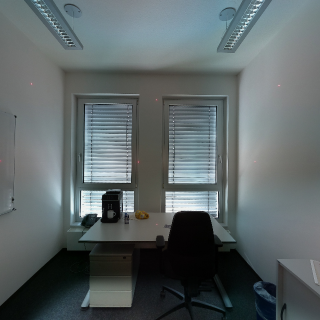

Das trainierte Modell liefert dazu die Wandübergänge in Form von Liniensegmenten die, mehr oder weniger gut, auf den jeweiligen Raumkanten liegen. Im vorliegenden Beispiel sind das ingesamt 8 Kanten (Links-Decke, Links-Boden, Links-Mitte, Mitte-Decke, Mitte-Boden, Mitte-Rechts, Rechts-Decke, Rechts-Boden). Das Modell liefert diese Kanten jedoch unsortiert und ohne Angabe über die Art des Übergangs. So sehen die gefundenen Kanten dann aus:
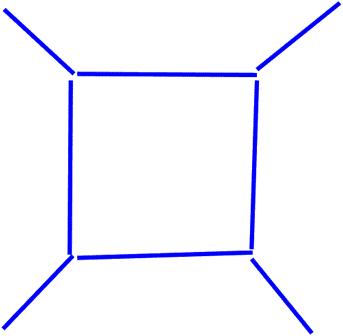

Es handelt sich bei den Kanten um Geradensegmente (Strecken) die jeweils aus einem Start- und einem Endpunkt bestehen. Das Problem: Neben den Wandübergängen hätten wir auch gerne die ungefähren Positionen der Raumecken (also dort, wo drei Wandübergänge aufeinandertreffen).

## Aufgabenstellung
Gegeben sind die von der KI gefundenen Wandübergänge in der Form ```[Startpunkt X, Startpunkt Y, Endpunkt X, Endpunkt Y]```. Schreiben die ein Programm, dass die aus den gegebenen Wandübergängen die Raumecken schätzt. Ihr Programm sollte allgemein für beliebige Räume funktionieren, Sie dürfen aber die Annahme treffen, dass das Raumlayout immer dem Beispiel hier entspricht (es sind also immer die 5 Raumbegrenzungen linke Wand, rechte Wand, mittlere Wand, Boden und Decke sichtbar.

Für das Beispiel oben liegen die Koordinaten der Kanten in Form einer Liste von Listen vor:

In [11]:
lines_raw = [[71, 75, 238, 76],
         [3, 15, 68, 75],
         [67, 244, 2, 312],
         [234, 241, 71, 246],
         [238, 71, 315, 9],
         [238, 81, 233, 238],
         [65, 81, 64, 243],
         [289, 316, 233, 247]]

Das Beispielbild liegt unter [shared_data/raumbilder/demoPosterViewIntensity_320.png](shared_data/raumbilder/demoPosterViewIntensity_320.png) und kann mit folgendem Code mit den Linien als Überlagerung angezeigt werden: 


In [6]:
import matplotlib.pyplot as plt
from PIL import Image


img = Image.open('shared_data/raumbilder/demoPosterViewIntensity_320.png')
fig, ax = plt.subplots(figsize=(5,5))
imgplot = plt.imshow(img)
for line in lines:
    x = line[0:3:2]
    y = line[1:4:2]
    ax.plot(x, y)
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'shared_data/raumbilder/demoPosterViewIntensity_320.png'

## Lösungsansatz
Hier stelle ich den, aus meiner Sicht, einfachsten Lösungsansatz vor. Das heißt natürlich nicht, dass das tatsächlich der einfachste Ansatz ist. Zudem ist er möglicherweise ungenauer als andere Ansätze. Das spielt aber aus meiner Sicht keine große Rolle, denn die Kantenvorhersage der KI ist auch nicht wirklich präzise. Zudem werden so wenig zusätzliche Bibliotheken wie möglich für die Berechnungen verwendet. Verwendet werden: ```math``` für die Wurzelfunktion und ```combinations``` aus ```itertools```.

Betrachtet man nur die Raumecke bei der Stirnwand, rechte Wand und Decke aufeinaner treffen, sieht das im Detail so aus:
<div>
<img src="attachment:image.png" width="50%"/>
</div>

Die Endpunkte der Wandübergänge sind mit ```P1``` für den Enpunkt der Linie zwischen rechter Wand und Decke, mit ```P2```für den Endpunkt der Linie zwischen Stirnwand und Decke sowie mit ```P3```für den Endpunkt der Linie zwischen rechter Wand und Stirnwand bezeichnet.  

Bei einem Idealen Modell sollten diese drei Punkte genau auf der Raumecke liegen. Das KI-Modell liefert aber derart genaue Ergebnisse nicht. Ein Schätzer für die Raumecke könnte (in einer sehr vereinfachten Betrachtung) der Punkt in der Mitte der drei Punkte liegen. Dieser Punkt kann aus dem Mittelwert der X-Koordinaten und der Y-Koordinaten der einzelnen Punkte ```P1``` bis ```P3``` berechnet werden. Also $ PM_x = (P1_x + P2_x + P3_x)/3 $ und $ PM_y = (P1_y + P2_y + P3_y)/3 $ 

Die Schwierigkeit besteht darin, diese drei Punkte zu finden. Dafür betrachten wir noch einmal das gesamte Bild mit den Raumkanten. In diesem Bild gibt es genau 4 Raumecken (unten mit A, B, C, D bezeichnet) in deren Nähe jeweils 3 Raumkanten aufeinander treffen.
<div>
<img src="attachment:image-2.png" width="50%"/>
</div>


Jeder der 4 Punkte A, B, C und D berechnet sich aus den drei nächstgelegenen Kantenendpunkten, welche modellbedingt nah beieinander liegen. So nah, dass keine weiteren Punkte in deren Nähe auftauchen können (alle Kanten sind länger, als die Abstände innerhalb der gesuchten Dreierpunkte und somit liegen auch die nächstgelegenen Dreierpunkte minstestens eine Kantenlänge weit weg). 

Die 8 Raumkanten bestehen aus jeweils 2 Punkten. Somit liegen 16 Punkte insgesamt vor, von denen wir zunächst alle möglichen Kombinationen von drei Punkten betrachten können. Von allen Kombinationsmöglichkeiten können die Abstände der drei Punkte berechnet werden. Die vier Kombinationen von drei Punkten mit den kleinsten Abständen (und allen Abständen kleiner als die Länge der küzesten Kante) sind die vier gesuchten Punkte A, B, C und D. In Summe sind das $\binom{16}{3}=560$ ([Binomialkoeffizient](https://de.wikipedia.org/wiki/Binomialkoeffizient)) mögliche Kombinationen von drei Pukten.
Von vorneherein können alle Dreierpunkte aussortiert werden, deren Abstand größer (oder gleich) der Länge der kürzesten Strecke in den Linien ist (denn dann können die aus den offensichtlichen, oben genannten Gründen, keine Dreierkombi der Punkte in A, B, C oder D sein). 

## Aufgabe 1
Ermitteln Sie die Länge der küzesten Strecke in ```lines``` (Reminder: [Euklidischer Abstand](https://de.wikipedia.org/wiki/Abstand#Euklidischer_Abstand)). Speichern Sie das Ergebnis in einer Variablen mit dem Namen ```minLineLength```. 

In [13]:
import math

def euklidian_norm(lines: list) -> list:
    """https://en.wikipedia.org/wiki/Norm_(mathematics)

    Args:
        lines (list): _description_

    Returns:
        list: _description_
    """
    line_length = []
    for i in range(len(lines)):
        line = lines[i]
        x_length = line[2] - line[0]
        y_length = line[3] - line[1]
        distance = math.sqrt(x_length**2 + y_length**2)
        line_length.append(distance)
    return line_length


# get shortest line from list of lines from raw data
lines = euklidian_norm(lines_raw)
lines.sort()
minLineLenght = lines[0]

print(minLineLenght)

88.45903006477066


## Aufgabe 2
Wandeln Sie die Liste ```lines``` mit den Liniensegmenten in eine Liste von Punkten um. Aus $N$ Liniensegmenten mit je zwei Punkten soll eine Liste mit $2N$ Punkten werden. Nennen Sie diese Variable bitte ```points```. 

In [4]:
# Ihr Code hier

## Aufgabe 3
Ermitteln Sie für alle 560 Kombinationen von drei Punkten, diejenigen Punktetriple, deren größter Abstand kleiner als die Länge der kürzesten Kante ist. Speichern Sie das Ergebnis in einer Liste mit dem Namen ```relevantTriplePoints```. Jeder Eintrag in der Liste sollte ein Tuple sein, mit den jeweiligen drei Punkten. Democode, wie die Ergebnisliste aufgebaut sein soll:
```
relevantTriplePoints = []
tmpTuple = (points[0],points[1],points[2])
relevantTriplePoints.append(tmpTuple)
```
_Tipp_: Für die Lösung können Sie die Funktion [combinations](https://docs.python.org/3/library/itertools.html#itertools.combinations) aus dem Paket [itertools](https://docs.python.org/3/library/itertools.html) verwenden. Alternativ können Sie auch drei schlau verschachtelte For-Schleifen verwenden.  

_Hinweis_: unten gibt es eine Grafik, die die richtigen Punkte, wenn gefunden und in der Variablen ```relevantTriplePoints``` abgelegt, anzeigt. Wenn Sie für alle 560 Punktetriple zusätzlich den maximalen Abstands jedes Tripels als Liste in eine Variable mit dem Namen ```allMaxDists``` als speichern, erhalten Sie ganz unten einen Plot zur Veranschaulichung der Abstände.

In [5]:
# Ihr Code hier

## Aufgabe 4
Berechnen Sie die mittleren Punkte für alle Punktetriple in ```relevantTriplePoints```. Speichern Sie das Ergebnis in als eine Liste von X-Y-Koordinaten in einer Variablen mit dem Namen ```cornerPoints```.

In [6]:
# Ihr Code hier

## Grafische Darstellung der Ergebnisse
Der Plot unten sollte, wenn Sie die Variablen korrekt benannt haben und die richtigen Werte enthalten sind, an die Linienenden, an denen 3 Linien aufeinander treffen pinke Kreise anzeigen. Die Schätzpunkte für die Raumecken sollten in als hellblaue Kreuze eingezeichnet werden.

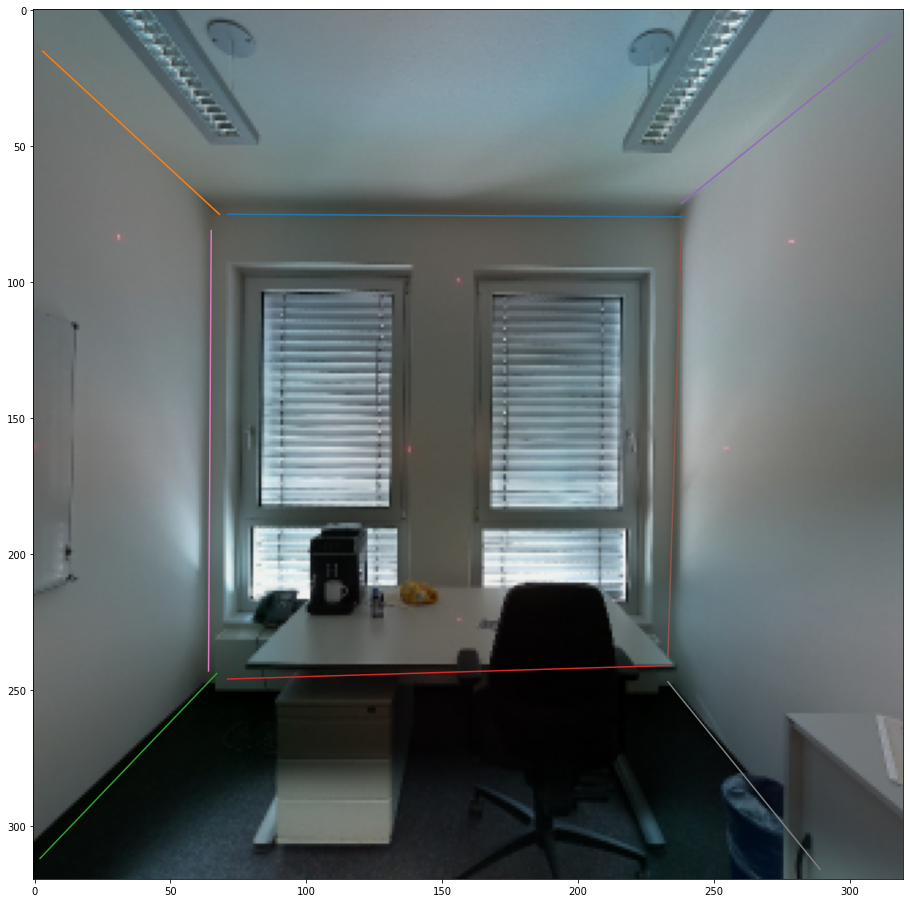

In [7]:
import matplotlib.pyplot as plt
from PIL import Image
img = Image.open('shared_data/raumbilder/demoPosterViewIntensity_320.png')
fig, ax = plt.subplots(figsize=(16,16))
imgplot = plt.imshow(img)
for line in lines:
    ax.plot(line[0:3:2], line[1:5:2])
if 'relevantTriplePoints' in locals():
    for pointtuple in relevantTriplePoints:
        for p in pointtuple:
            ax.scatter(p[0], p[1], s=100, c='m', marker='o')
if 'cornerPoints' in locals():
    for point in cornerPoints:
        ax.scatter(point[0], point[1], s=200, c='c', marker='x',linewidths=2)
plt.show()

Der Code unten erzeugt eine Balkengrafik, die die 20 kleinsten der größten Abstände innerhalb einer Dreierkombination von Punkten anzeigt. Das veranschaulicht, warum von allen berechneten Dreierkombinationen nur 4 als relevant übrig bleiben.

In [8]:
if 'allMaxDists' in locals():
    allMaxDists = sorted(allMaxDists)
    N = 20
    fig, ax = plt.subplots(figsize=(16,4))
    
    ax.bar(range(1,N+1),allMaxDists[:N])
    ax.plot([.5,N+.5],[minLineLength,minLineLength],'-r')
    plt.xticks(range(1,N+1))
    plt.title('Die 20 kleinsten maximalen Abstände eines Tripels (blaue Balken) mit Länge der kürzesten Kante rote Linie)')
    plt.grid(axis='y')
    plt.show()